In [24]:
import fit_classes as fp
import numpy as np
import os
from scipy.interpolate import interp1d
from scipy import optimize
import pandas as pd

errors = []
ERROR = 0.1 # Error in mV

# class DataPlus(fp.Data):
    
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)

#         def sinus_model(params, x):
#             A,f,phi,c = params
#             return A*np.sin(2*np.pi*f*x + phi) + c
        
#         file = os.path.join(os.path.abspath(os.getcwd()), "data", "params.txt")
#         name = str(self.name).split("\\")[-1]
#         var = None
#         vals = []
#         with open(file, "r") as file:
#             for line in file:
#                 vals.append((
#                     line.strip().split(": ")[0],
#                      tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))
#                     ))

#         check = False
#         for var in vals:
#             if var[0] == name:
#                 A, f, phi, c = var[1]
#                 check = True
                
#         if check == False:
#             A, f, phi, c = 100, 0.006, -13.06097, 25
#             A = (np.abs(max(self.y)) + np.abs(min(self.y)))/2
#             c = (max(self.y) + min(self.y))/2

#             f_interp = interp1d(self.x, self.y, kind='cubic')
#             x_dense = np.linspace(self.x.min(), self.x.max(), 1000)
#             y_dense = f_interp(x_dense)

#             crossings = []
#             for i in range(len(x_dense)-1):
#                 if (y_dense[i] - c) * (y_dense[i+1] - c) < 0:  # Sign change
#                     # Refine crossing with brentq
#                     root = optimize.brentq(lambda x_val: f_interp(x_val) - c, x_dense[i], x_dense[i+1])
#                     crossings.append(root)
#                     # punt
#                     # if self.x[list(self.x).index(punt) - 5] > self.x[list(self.x).index(punt) + 5]:
#                     #     dalende_root.append(punt)

            
#             # Find descending zero-crossings
#             stijgende_root = []
#             for i in range(len(self.y) - 2):
#                 if (self.y[i - 1] + self.y[i - 2])/2 < c and (self.y[i + 1] + self.y[i + 2])/2 >= c and self.x[i] > 10:
#                     if stijgende_root != []:
#                         if self.x[i] - stijgende_root[-1] > 10:
#                             stijgende_root.append(self.x[i])
#                     else:
#                         stijgende_root.append(self.x[i])
            
#             crossing_count = len(crossings)
#             # crossing_count = crossing_count if crossing_count < 30 else 30
#             # f = 0.00101048 if abs(len(crossings) - 21) < abs(len(crossings) - 42) else 0.00239959
#             f = 1/2
#             # phi  = -(stijgende_root[0]*f)*2*np.pi
#             phi = 0
#             # A = 8

#         # phi = np.arcsin(self.x[0] / A)

#         SKIP_POINTS = 1

#         self.x = self.x[::SKIP_POINTS]
#         self.y = self.y[::SKIP_POINTS]
#         self.dx = self.dx[::SKIP_POINTS]
#         self.dy = self.dy[::SKIP_POINTS]

#         self.fit = self.fit(sinus_model, initial_guess=(A, f, phi, c))
#         self.fit.init = A, f, phi, c

#         if check == False:
#             file = os.path.join(os.path.abspath(os.getcwd()), "data", "params.txt")
#             if self.fit.chi2_red < 10:
#                 values = (float(A), float(f), float(phi), float(c))
#                 with open(file, "a") as file:
#                     file.write(f"{name}: {values}\n")


#         self.A, self.f, self.phi, self.c = self.fit.minima

def data_from_file(file):
    file_path = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), file)
    name = str(file_path).split("/")[-1]
    df = pd.read_csv(file_path, delimiter=';', decimal=',')
    df.columns = df.columns.str.strip()

    SKIP1 = 1
    SKIP2 = 5

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "superposition.txt")
    vals = []
    var = None
    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(int, line.strip().split(": ")[-1].strip("()").split(", ")))))

    check = False

    for var in vals:
        if var[0] == name:
            SKIP1, SKIP2 = var[1]
            check = True

    if not check:
        if True:
            values = (SKIP1, SKIP2)
            with open(file_p, "a") as file:
                file.write(f"{name}: {values}\n")

    x1 = df["Latest: Time (s)"].to_numpy()[::SKIP1]
    x2 = df["Latest: Time (s)"].to_numpy()[::SKIP2]
    y1 = df["Latest: Potential 1 (V)"].to_numpy()[::SKIP1]
    y2 = df["Latest: Potential 2 (V)"].to_numpy()[::SKIP2]
    dy1 = ERROR*np.ones_like(y1)
    dy2 = ERROR*np.ones_like(y2)

    data1 = fp.Data(x1, y1, dy1, name=str(file_path).split('/')[-1][0:-4] + '_1')
    data2 = fp.Data(x2, y2, dy2, name=str(file_path).split('/')[-1][0:-4]  + '_2')
    return data1, data2

        
def load_data_by_folder(root):
    folder_data = {}
    total_files = 0
    total_files += len([f for f in os.listdir(root)])

    current_file = 0
    data_list_input = []
    data_list = []
    for file in os.listdir(root):
        file_path = os.path.join(root, file)
        if os.path.isfile(file_path) and file.lower().endswith(".csv"):
            current_file += 1
            # os.system(f'echo "File: {current_file:>3}/{total_files}"')
            data1, data2 = data_from_file(file_path)
            data_list_input.append(data1)
            data_list.append(data2)
        
    if data_list:
        folder_data = np.array(data_list)
    return folder_data

data_arrays = load_data_by_folder(os.path.join(os.path.abspath(os.getcwd()), "data"))


2-4_180Hz_2


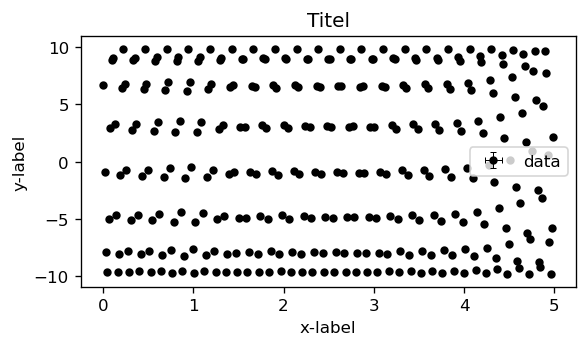

2-4_195Hz_2


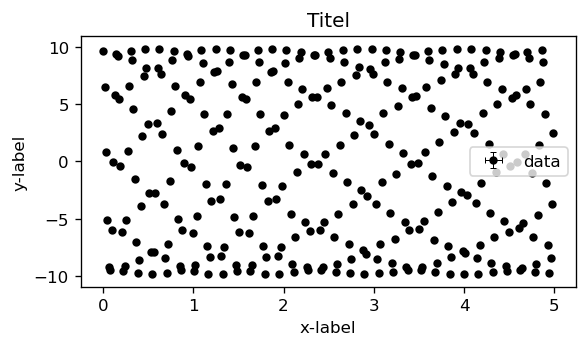

2-3_300Hz_2


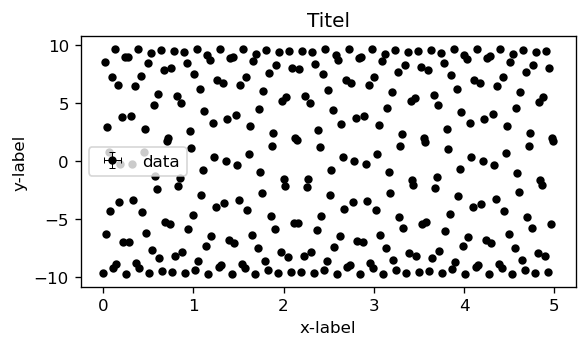

2-5_190Hz_2


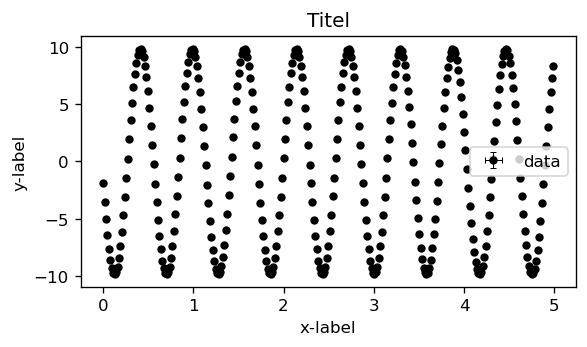

2-4_200Hz_2


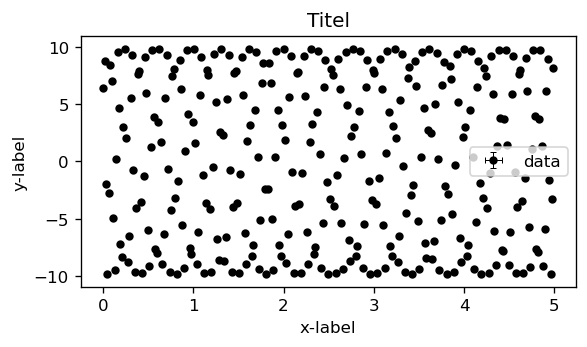

2-3_200Hz_2


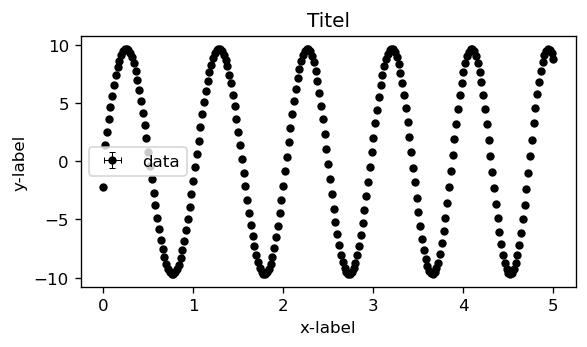

2-3_280Hz_2


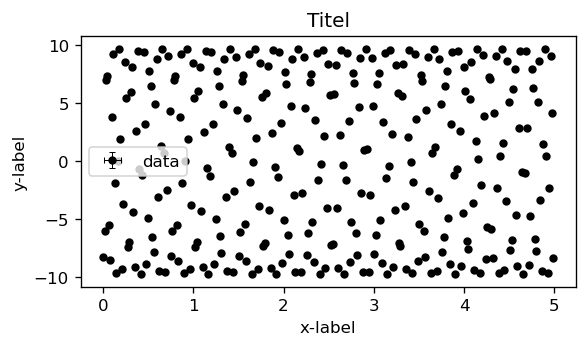

2-2_20Hz_2


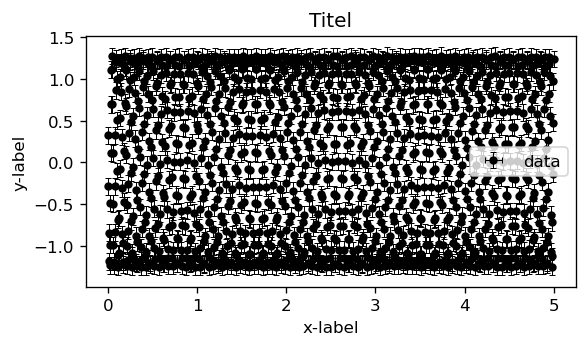

2-5_170Hz_2


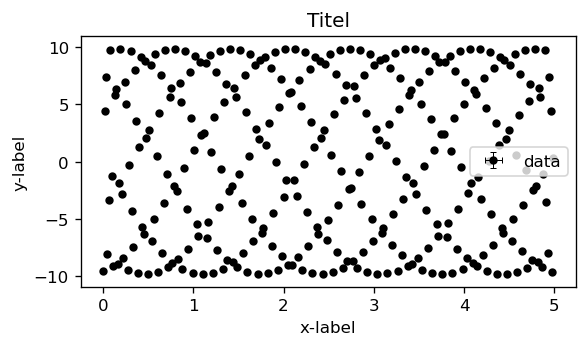

2-2_30Hz_2


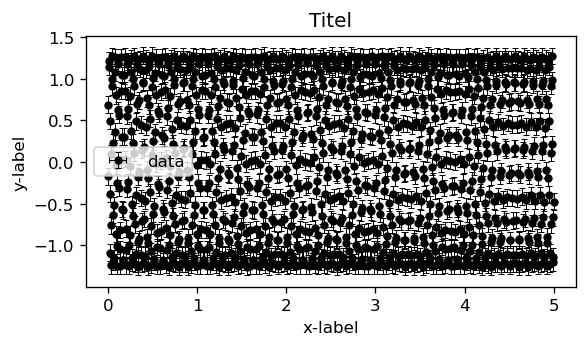

2-4_300Hz_2


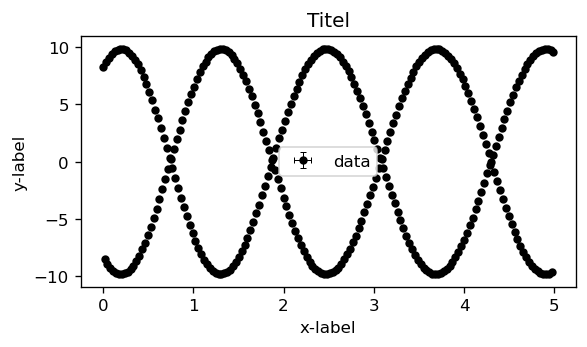

2-5_100Hz_2


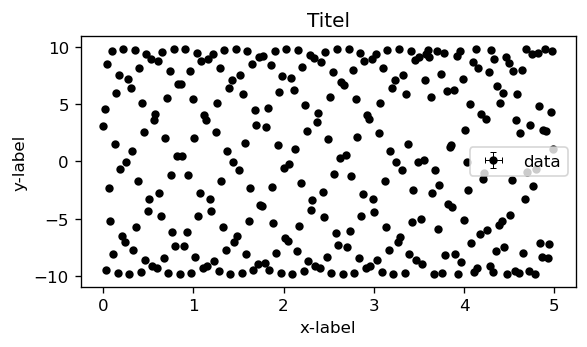

2-4_190Hz_2


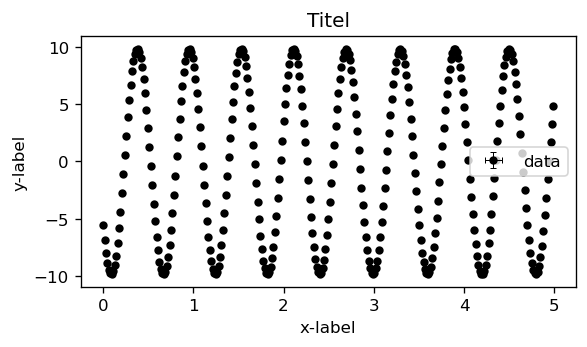

2-2_2.5Hz_2


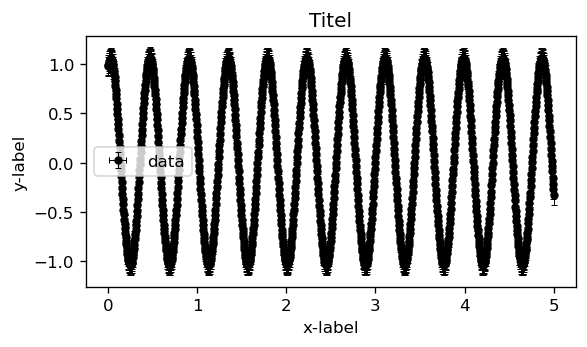

2-2_1.5Hz_2


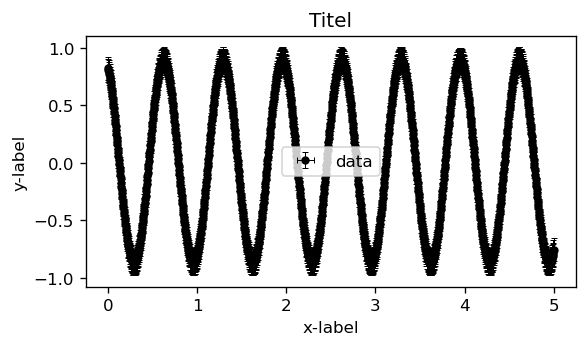

2-3_210Hz_2


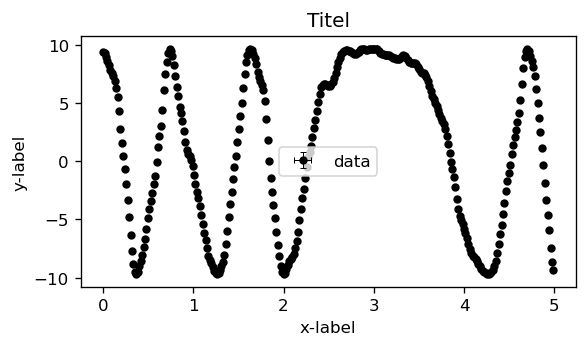

2-2_15Hz_2


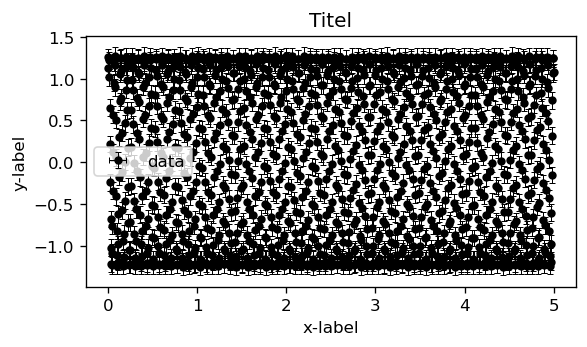

2-2_3Hz_2


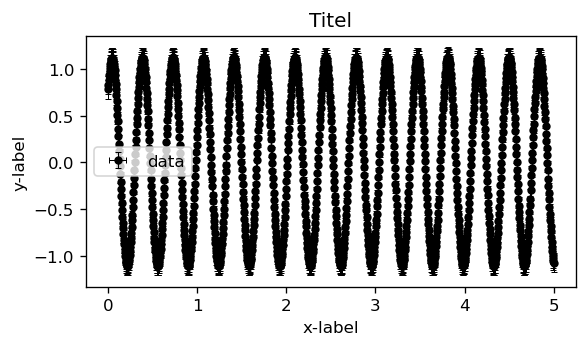

2-5_150Hz_2


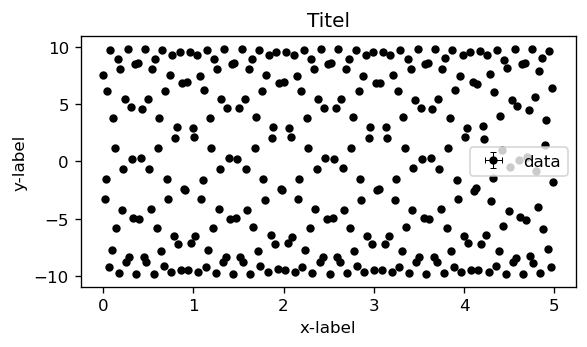

2-5_185Hz_2


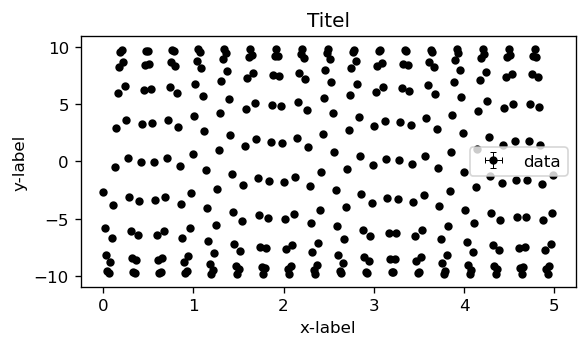

2-4_150Hz_2


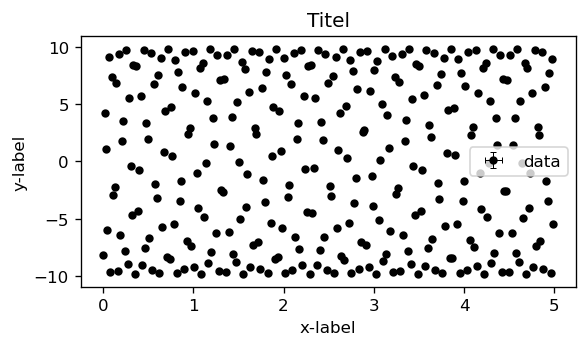

2-3_100Hz_2


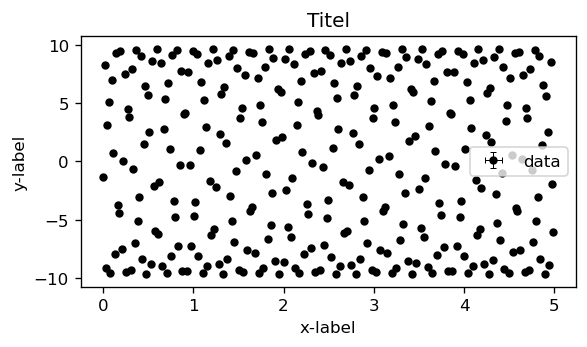

2-5_200Hz_2


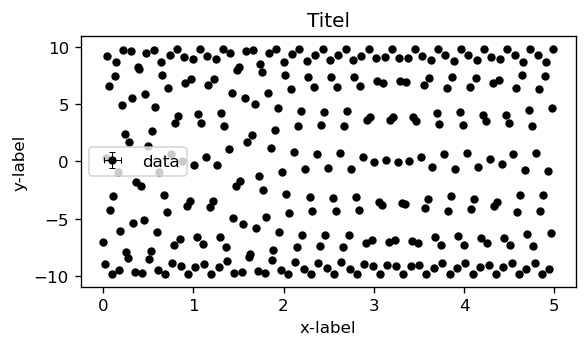

2-4_170Hz_2


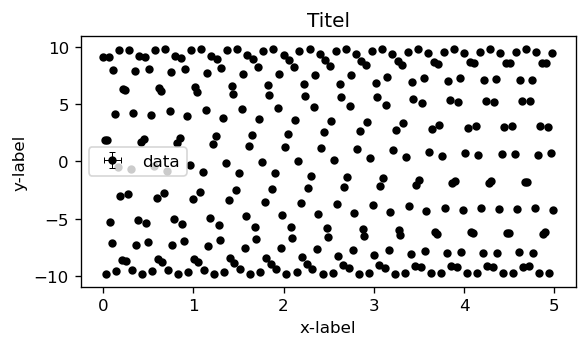

2-2_7Hz_2


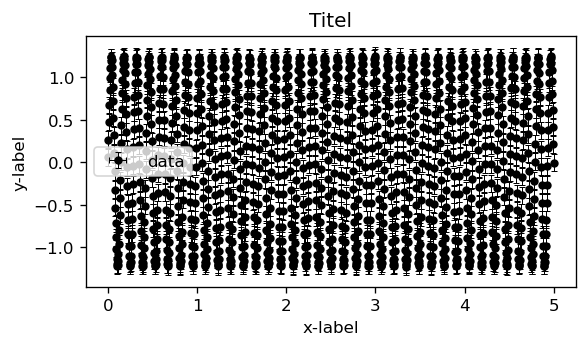

2-3_250Hz_2


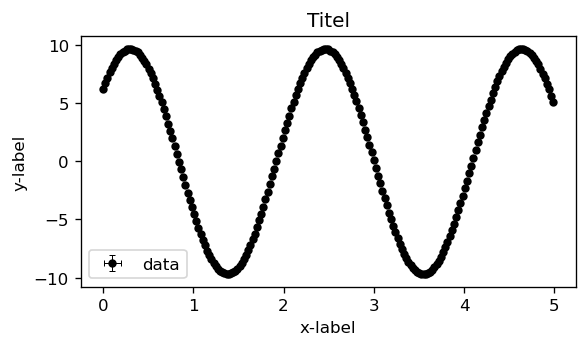

2-2_4Hz_2


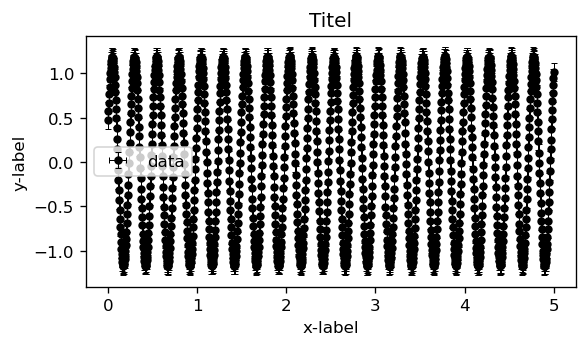

2-4_160Hz_2


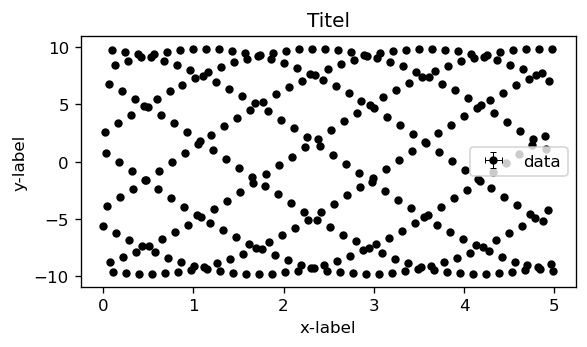

2-2_9Hz_2


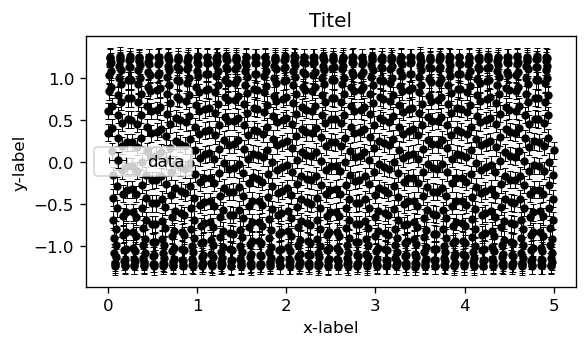

2-2_5Hz_2


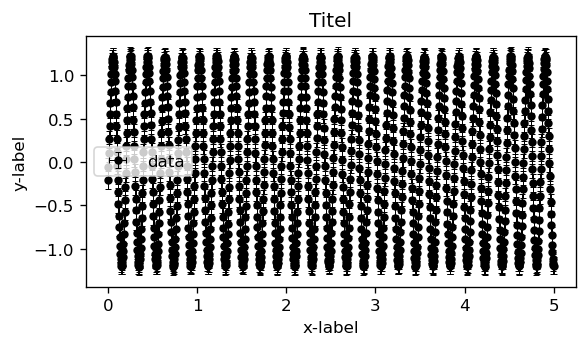

2-5_160Hz_2


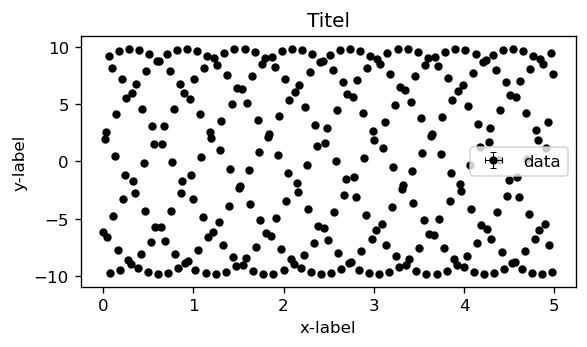

2-4_250Hz_2


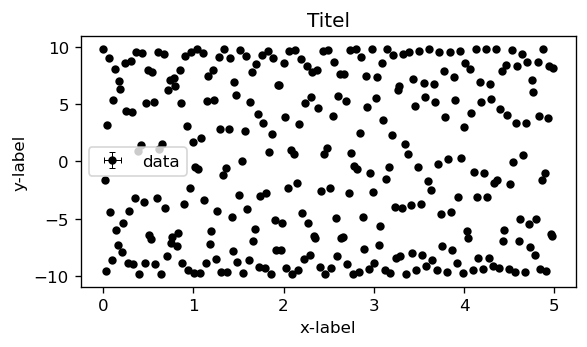

2-2_2Hz_2


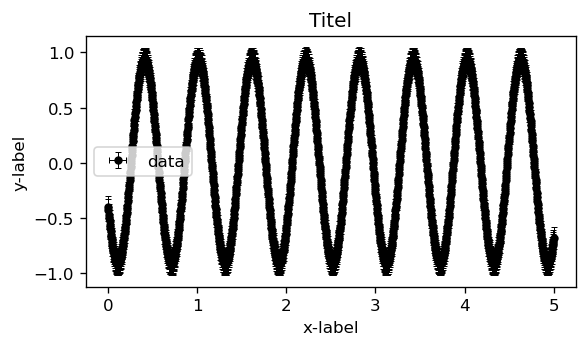

2-3_240Hz_2


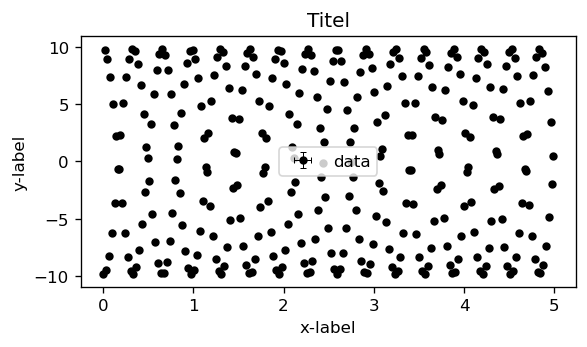

2-3_220Hz_2


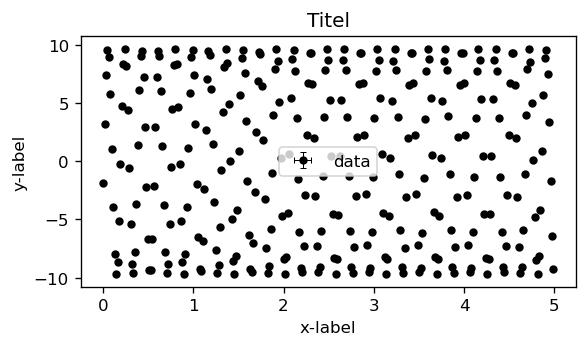

2-2_10Hz_2


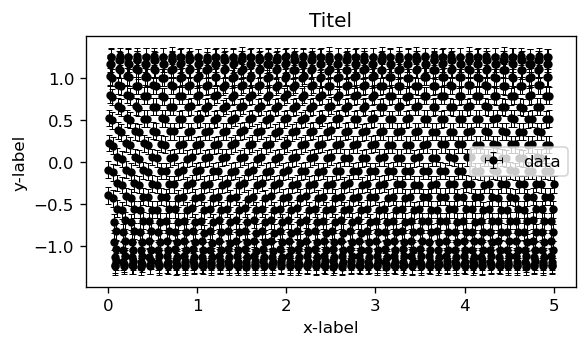

2-1_2


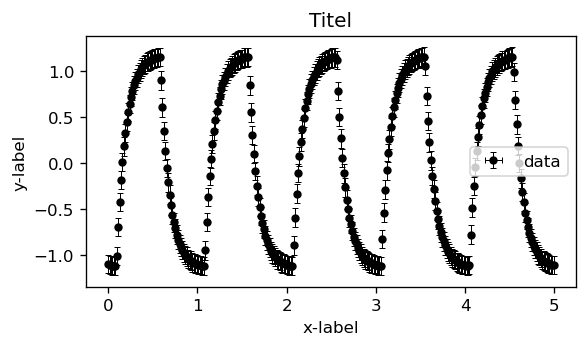

2-2_8Hz_2


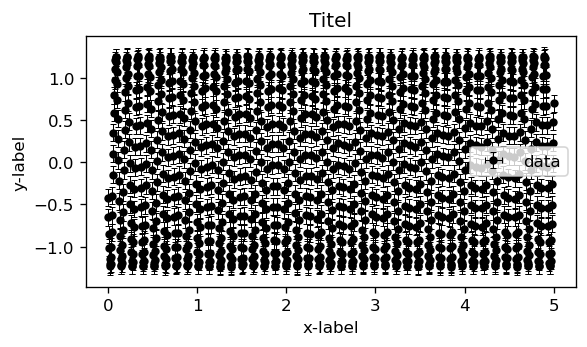

2-5_180Hz_2


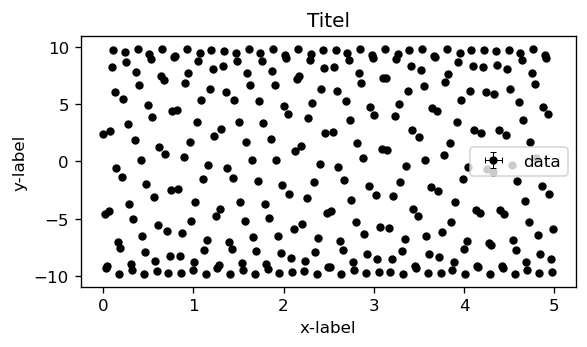

2-2_1Hz_2


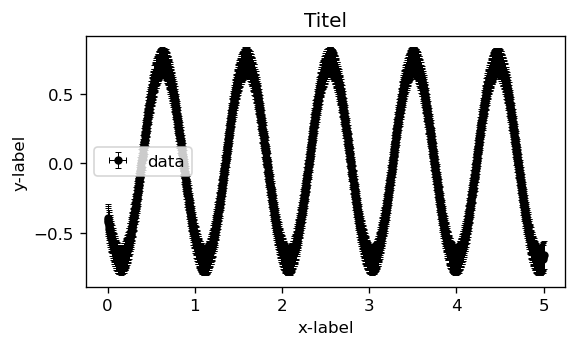

2-4_100Hz_2


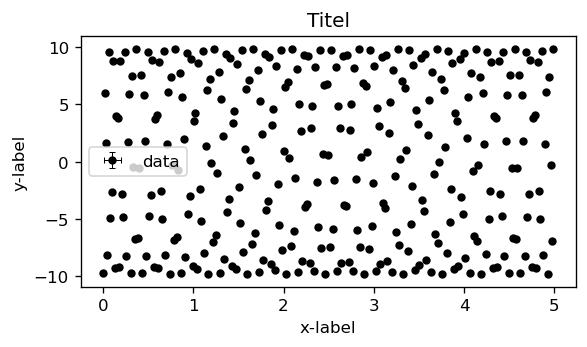

2-2_6Hz_2


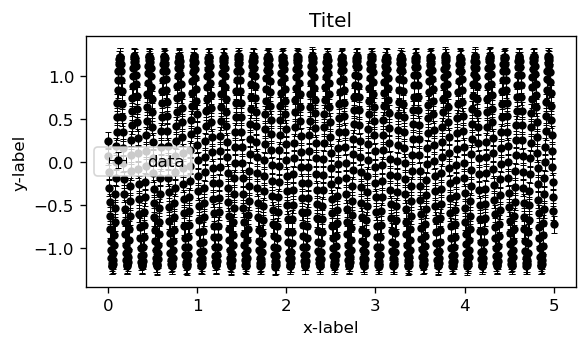

In [22]:
datadict = {}
for dataset in data_arrays:
    datadict[dataset.name[0:-2]] = dataset
    # if dataset[1].name == '2-5_190Hz_2':
    print(dataset.name)
    dataset.show()
    # print(dataset[1].fit.init)
         
# datadict["2-3_250Hz"].show()